# Initial Test Data Analysis
See [This GitLAB Issue](https://code.crearecomputing.com/hearingproducts/open-hearing-group/open-hearing-hardware/-/issues/1) for details ont he data collection. 

In this notebook:

0. Load Common Data Structure (Setup)
1. Fine-tune calibration of mic positions
2. Mic amplitude calibrations
3. Mic phase calibrations

## 0. Load Common Data Structures

In [1]:
%matplotlib inline

In [2]:
# Import dependencies
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, ndimage, optimize
from pint import UnitRegistry

from owai.core import io
from owai.core import signal_processing_utils as spu
from owai.core.model import StraightTube
from owai.core.units import units

In [3]:
# Figure style and line style
figkwargs = dict(figsize=(6.5, 6.5 / 1.618034), dpi=200)
linekwargs = dict(lw=1, alpha=0.5)

# Set up path to the data
path = os.path.join("Olympus", "Projects", "1010564-OPEN-HEARING", "Technical Work", "Testing", "Data", "2024-02-23_OWAI-Calibration-Data-Collection")  # From windows
path_speaker_cal = os.path.join("Olympus", "Projects", "1010564-OPEN-HEARING", "Technical Work", "OWAI Design", "Rau-34832-b148-calibration-curve.csv")  # From windows
if os.environ.get("OLYMPUS_PROJECTS_PATH", False):
    path = path.replace(os.path.join('Olympus', "Projects"), os.environ.get("OLYMPUS_PROJECTS_PATH"))
    path_speaker_cal = path_speaker_cal.replace(os.path.join('Olympus', "Projects"), os.environ.get("OLYMPUS_PROJECTS_PATH"))
print("Looking for data in this path:", path)

path_meta = os.path.join(path, 'testdata.yaml')
print("Looking for test meta data in this path:", path_meta)

# Load test metadata
test_meta = io.load_test_data(path_meta)
# pprint(test_meta)

# Load nominal speaker calibration
speaker_cal = np.genfromtxt(path_speaker_cal, delimiter=',')
sort_inds = np.argsort(speaker_cal[:, 0])
speaker_cal = speaker_cal[sort_inds]
del sort_inds

# Set constants
speed_of_sound = 343 * units.m / units.s
n_channels = 4

Looking for data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-02-23_OWAI-Calibration-Data-Collection
Looking for test meta data in this path: /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-02-23_OWAI-Calibration-Data-Collection/testdata.yaml


# 1. Fine-Tune Mic Positions

Idea is to see how an impulse travels across the array and see if timing matches up with the expected geometry.

In [4]:
lengths_nominal = test_meta["probe_geometry"]['mic_positions']['value'] * units(test_meta["probe_geometry"]['mic_positions']['units'])
lengths_nominal

Magnitude,[0.4 5.9 9.5 13.4]
Units,millimeter


In [5]:
# Load all availabl data, and concatenate
times = []
data = []
last_t = 0
for tests in test_meta["test_metadata"]["impulse"]["files"]:
    fn = os.path.join(path, tests[0])
    t, d, samplerate = io.load_wav(fn)
    times.append(t + last_t)
    last_t = t[-1] + last_t + t[1]
    data.append(d)
times = np.concatenate(times)
data = np.concatenate(data)

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000


In [6]:
# plt.close(1)
# plt.figure(1, **figkwargs)
# plt.plot(times, data, **linekwargs)
# plt.xlabel("time (s)")
# plt.ylabel("amplitude (uncal)")
# plt.title("Impulse data")
# plt.legend(range(4))
# plt.show()

In [7]:
# Let's find all the max events in the file

# First, subtract out the mean up to the current point. This lets us find jumps in the data with a threshold
kernel_size = 65
kernel_lag_mean = np.ones(kernel_size)
kernel_lag_mean[:kernel_size // 2 + 1] = 0  # Reversed because convolutions flip the kernel... so we average the data to the left
kernel_lag_mean /= kernel_lag_mean.sum()
data_lag_mean = ndimage.convolve1d(data, kernel_lag_mean, axis=0)
data_minus_mean = data - data_lag_mean

# Now find the maxima in the data with the means removed
data_max = ndimage.maximum_filter1d(np.abs(data_minus_mean), kernel_size, axis=0)

# Figure out an appropriate threshold to identify "events"
# channel_noise_max = data_minus_mean[:samplerate].max(axis=0)
channel_noise_std = data_minus_mean[:samplerate].std(axis=0)
channel_noise_thresh = (channel_noise_std).max() * 100

# Now find the location of the events
inds_event = np.all(data_max > channel_noise_thresh, axis=1)
data_event = data_minus_mean[inds_event]
time_event = times[inds_event]

# find indices where events start... the starts of blocks of True
ints_event = np.argwhere((inds_event[1:] == True) & (inds_event[:-1] == False))[:, 0] + 1

# Events should be separated by at least 0.25 seconds
EVENT_SEPARATION_SECONDS = 0.25
ints_event = np.concatenate([ints_event[:1], ints_event[ints_event > np.roll(ints_event, 1) + samplerate * EVENT_SEPARATION_SECONDS]])

Text(0, 0.5, 'Amplitude (uncal)')

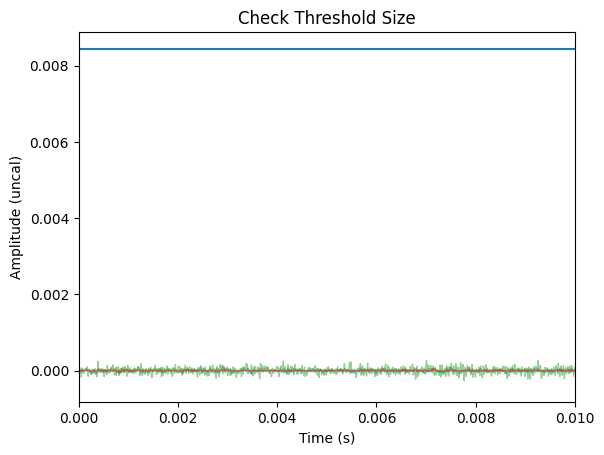

In [8]:
# Debug Plot
plt.close(101)
plt.figure(101)
n = samplerate
plt.plot(times[:n], data_minus_mean[:n, :], **linekwargs)
plt.gca().set_prop_cycle(None)
plt.plot([times[0], times[n]], [channel_noise_thresh]*2)
plt.xlim(0, 0.01)
plt.title("Check Threshold Size")
plt.xlabel('Time (s)')
plt.ylabel("Amplitude (uncal)")

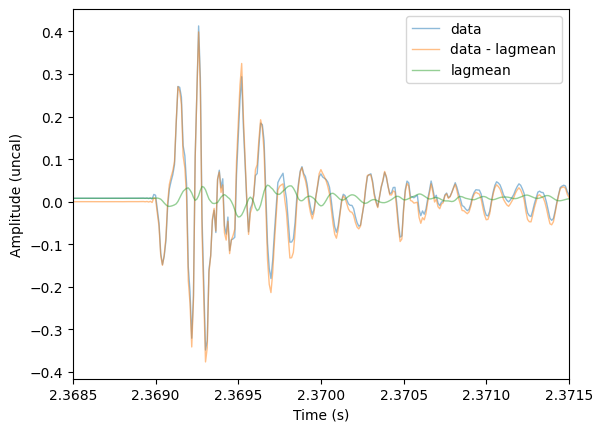

In [9]:
# Debug Plot
plt.close(102)
plt.figure(102)
n = samplerate*4
plt.plot(times[:n], data[:n, 0], **linekwargs)
plt.plot(times[:n], data_minus_mean[:n, 0], **linekwargs)
plt.plot(times[:n], data_lag_mean[:n, 0], **linekwargs)
plt.gca().set_prop_cycle(None)
# plt.plot([times[0], times[n]], [channel_noise_thresh]*2)
plt.legend(["data", "data - lagmean", "lagmean"])
plt.xlim(2.3685, 2.3715)
plt.xlabel('Time (s)')
plt.ylabel("Amplitude (uncal)");

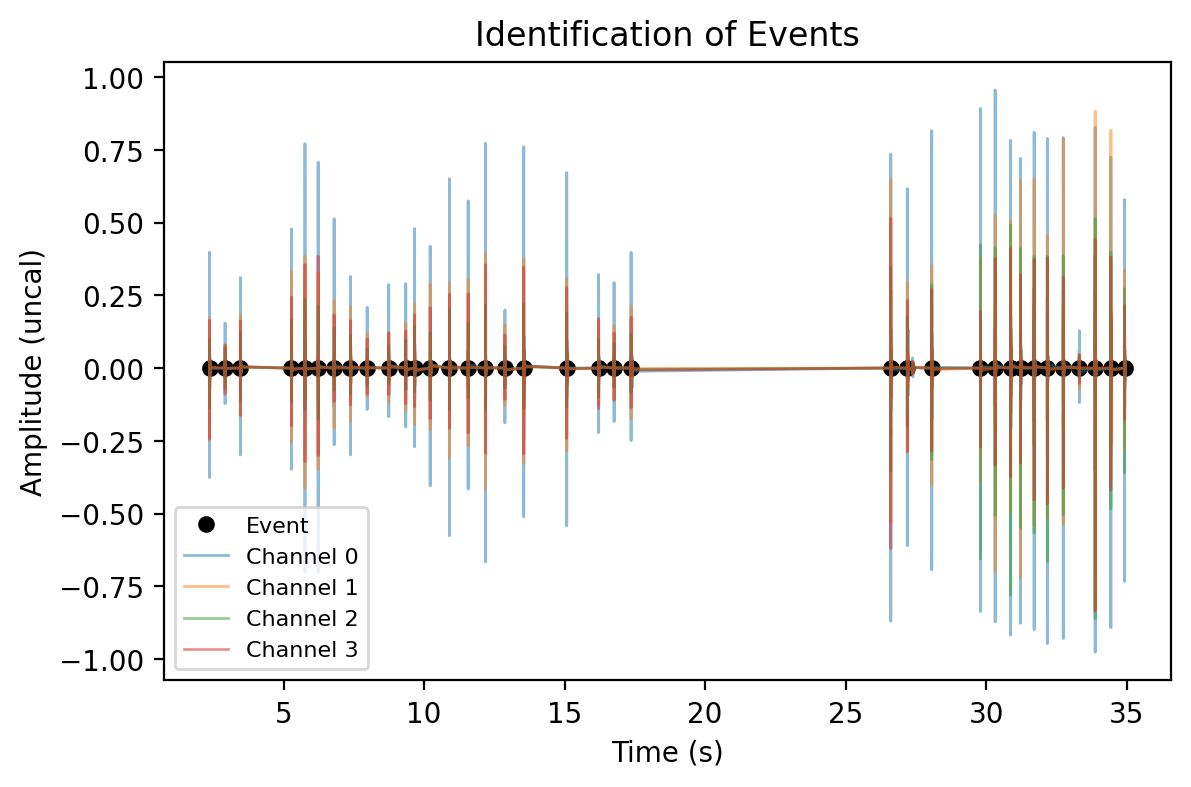

In [10]:
plt.close(2)
plt.figure(2, **figkwargs)
plt.plot(times[ints_event], ints_event * 0, 'ok', ms=5)
plt.plot(time_event, data_event, **linekwargs)
# plt.plot(times, data_minus_mean, **linekwargs)
plt.title("Identification of Events")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uncal)")
plt.legend(["Event", "Channel 0", "Channel 1", "Channel 2", "Channel 3"], fontsize=8, loc=3)
plt.show();

In [11]:
# Only look at the data up to the first extremum
data_max3 = ndimage.maximum_filter1d(np.abs(data_minus_mean), 3, axis=0)
data_max3_inds = (data_max3 == np.abs(data_minus_mean)) & (data_max3 > channel_noise_thresh)
data_max3_nans = np.ones(data_max3_inds.shape) # For plotting
data_max3_nans[~data_max3_inds] = np.nan

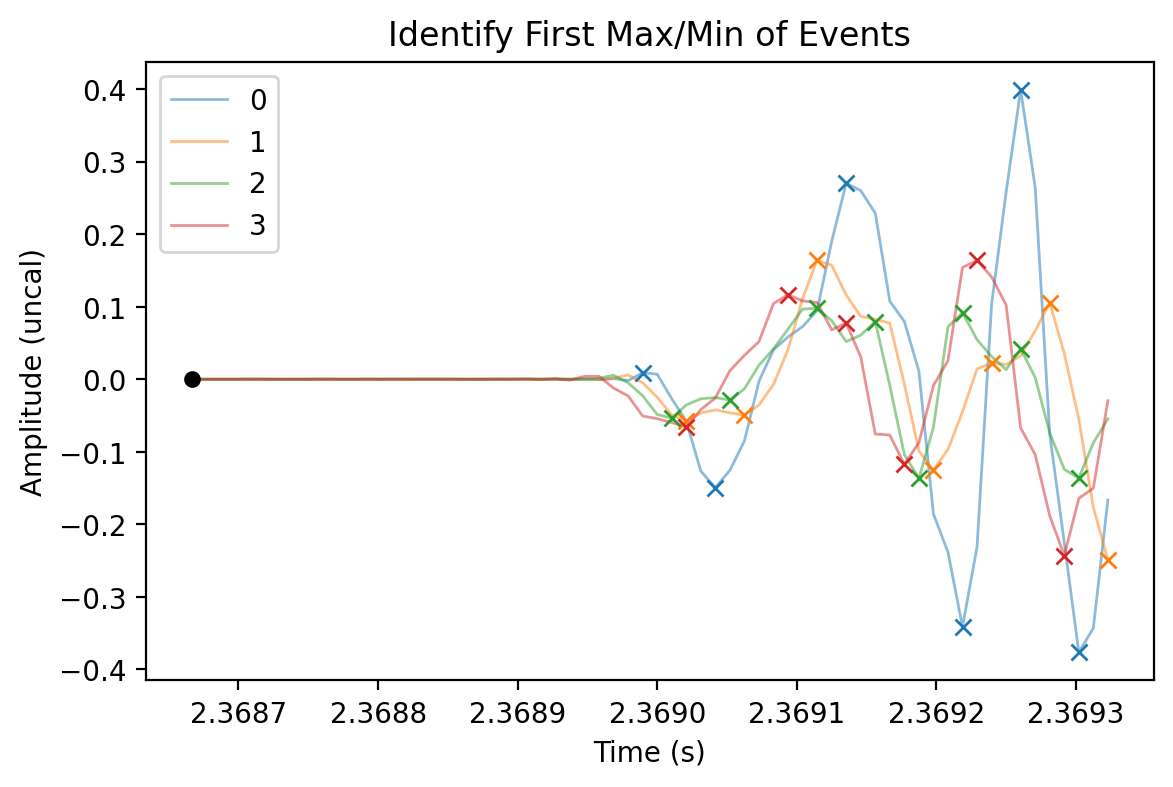

In [12]:
# Plot the first event
event_ind = 0
slc = slice(ints_event[event_ind], ints_event[event_ind] + 64)
plt.close(3)
plt.figure(3, **figkwargs)
plt.plot(times[slc], data_minus_mean[slc], **linekwargs)
plt.gca().set_prop_cycle(None)
plt.plot(times[slc], data_max3_nans[slc] * data_minus_mean[slc], 'x')
plt.plot(times[slc.start], 0, 'ok', ms=5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uncal)")
plt.title("Identify First Max/Min of Events")
plt.legend(range(4))
plt.show()

In [13]:
# find the indices for all of these "first max after event" for all channels and all events
ints_local_maxes = [np.argwhere(data_max3_inds[:, c])[:, 0] for c in range(n_channels)]

# Subselect the data for all these event, and add a buffer around the signal for sub-sample alignment
data_buffer = 6  # At least 1

data_segment_lenghts = 16
event_data_segments = np.zeros((ints_event.size, data.shape[1], data_segment_lenghts + 2 * data_buffer))
event_data_times = np.zeros((ints_event.size, data.shape[1], data_segment_lenghts + 2 * data_buffer))
event_start_stop_inds = []
for i, int_event in enumerate(ints_event):
    for c in range(n_channels):
        stop = ints_local_maxes[c][np.argwhere(ints_local_maxes[c] > int_event)[0, 0]] + 1
        if stop < (int_event + data_segment_lenghts):
            # Something went wrong, don't include this event
            continue
        slc = slice(stop - data_segment_lenghts - data_buffer, stop + data_buffer)
        event_data_segments[i, c, :] = data_minus_mean[slc, c]
        event_data_times[i, c, :] = times[slc]

# Eliminate unpopulated events
keep = ~np.all(event_data_segments[:, 0] == 0, axis=-1)
event_data_segments = event_data_segments[keep, :, :]
event_data_times = event_data_times[keep, :, :]

# normalize
event_data_times_norm = event_data_times - event_data_times[:, :, :1]
event_data_times_ref = event_data_times - event_data_times[:, -1:, :1]
event_data_segments_norm = event_data_segments / event_data_segments[:, :, -data_buffer-1:-data_buffer]

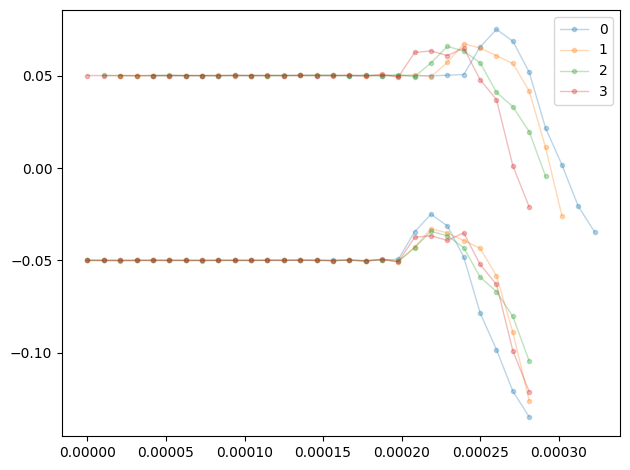

In [14]:
# debug plot
e = 7
plt.close(103)
plt.figure(103)
shift = event_data_segments[e, :].max()
for i in range(n_channels):
    # plt.plot(event_data_times[e, i], event_data_segments_norm[e, i], ".-C" + str(i), lw=1, alpha=0.3)
    plt.plot(event_data_times_ref[e, i], event_data_segments[e, i] * [0.5, 1, 1,1][i] + shift, ".-C" + str(i), lw=1, alpha=0.3)
for i in range(n_channels):
    plt.plot(event_data_times_norm[e, i], event_data_segments[e, i] * [0.5, 1, 1,1][i] - shift, ".-C" + str(i), lw=1, alpha=0.3)
plt.legend(range(n_channels))
plt.tight_layout()
plt.show()

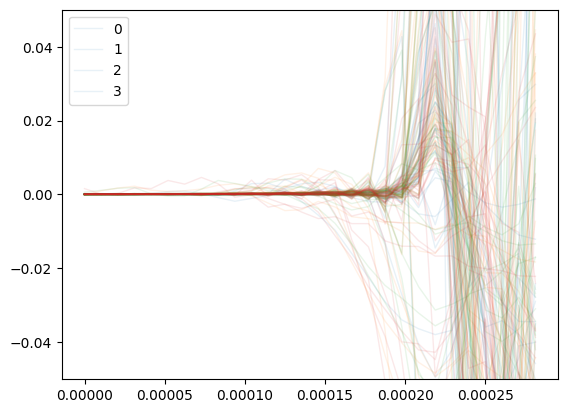

In [15]:
# debug plot
e = 7
plt.close(104)
plt.figure(104)
# for i in range(n_channels):
#     plt.plot(event_data_times_norm[e, i], event_data_segments[e, i], ".-C" + str(i), lw=1, alpha=0.3)
# for i in range(n_channels):
#     plt.plot(event_data_times_ref[0, i], event_data_segments[0, i], ":C" + str(i), lw=1, alpha=0.3)
for i in range(n_channels):
    plt.plot(event_data_times_norm[:, i].T, event_data_segments[:, i].T * [0.5, 1, 1,1][i], "C" + str(i), lw=1, alpha=0.1)
plt.legend(range(n_channels))
plt.ylim([-shift, shift])
plt.show()

In [16]:
# Compute the sub-sample offsets of all these events
ref_channel=-1
offsets, costs, old_costs = spu.find_subsample_alignment_offsets(
    event_data_times_ref, event_data_segments, buffer=data_buffer, ref_channel=ref_channel, cost_type="corr")
event_data_times_norm_off = event_data_times_norm + offsets[..., None]

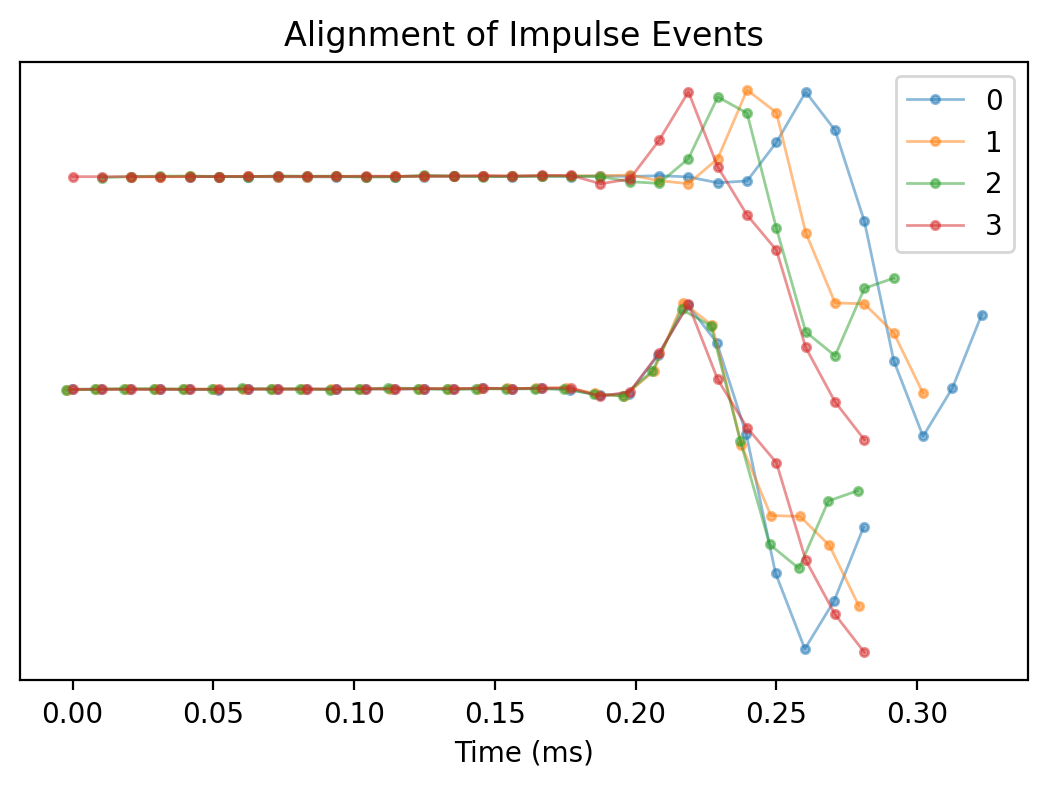

In [17]:
e = 1
shift = event_data_segments[e, :].max() / 2
plt.close(4)
plt.figure(4, **figkwargs)
for i in range(n_channels):
    # Multiply first channel by half because it contains the reflection (i.e. double the pressure)
    plt.plot((event_data_times_ref[e, i] + offsets[e, i]) * 1000,-shift + event_data_segments[e, i] * [0.4, 1, 1, 1][i], ".-C" + str(i), **linekwargs)
for i in range(n_channels):
    plt.plot(event_data_times_ref[e, i] * 1000, shift + event_data_segments[e, i] * [0.4, 1, 1, 1][i], ".-C" + str(i), **linekwargs)
plt.legend(range(n_channels))
plt.xlabel("Time (ms)")
plt.yticks([])
plt.title("Alignment of Impulse Events")
plt.show()

In [18]:
# Now we have everything we need to compute distance the offsets
# rough_offset = (((event_data_times[:, :, 0] - event_data_times[:, ref_channel, 0][:, None]) * units.s) * speed_of_sound).to('mm')
fine_offsets = ((offsets * units.s) * speed_of_sound).to('mm')
expected_offsets = lengths_nominal[:] - lengths_nominal[-1]

iter = 6
offset_mask = np.abs(fine_offsets - expected_offsets) < (1 * units.mm)
# Remove outliers iteratively
for i in range(iter):
    fine_offset = (fine_offsets * offset_mask).sum(axis=0) / offset_mask.sum(axis=0)
    offset_std = np.sqrt((offset_mask * (fine_offsets - fine_offset) ** 2).sum(axis=0) / offset_mask.sum(axis=0))
    offset_mask = np.abs(fine_offsets - fine_offset) < offset_std * 3
    offset_mask[:, ref_channel] = True
    print(fine_offset)
# shift coordinates to align with nominal lengths
fine_offsets = fine_offsets - fine_offset[-1] + lengths_nominal[-1]
fine_offset = fine_offset - fine_offset[-1] + lengths_nominal[-1]
fine_offset

[-13.466963949377517 -7.629245734668778 -3.8559167510469807 0.0] millimeter
[-13.880282209970167 -7.6553326356496365 -3.82281765037401 0.0] millimeter
[-13.880282209970167 -7.65545989565344 -3.7777903626890663 0.0] millimeter
[-13.880282209970167 -7.603873047093513 -3.7777903626890663 0.0] millimeter
[-13.880282209970167 -7.603873047093513 -3.7777903626890663 0.0] millimeter
[-13.880282209970167 -7.603873047093513 -3.7777903626890663 0.0] millimeter


Magnitude,[-0.48028220997016646 5.796126952906487 9.622209637310934 13.4]
Units,millimeter


/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Text(0.5, 1.0, 'Mic Positions')

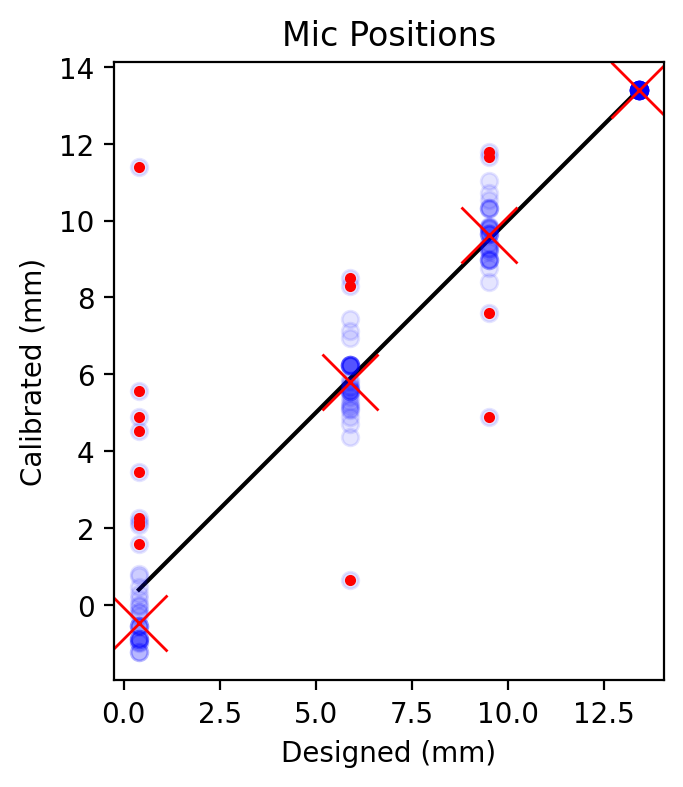

In [19]:
plt.close(8)
plt.figure(8, **figkwargs)
offset_nan = np.ones(offset_mask.shape)
offset_nan[offset_mask] = np.nan
plt.plot(lengths_nominal, lengths_nominal, 'k')
plt.plot(lengths_nominal, fine_offsets.T, 'bo', alpha=0.1)
plt.plot(lengths_nominal, fine_offsets.T * offset_nan.T, 'r.', alpha=1)
plt.plot(lengths_nominal, fine_offset, 'rx', ms=20)
plt.axis('scaled')
# plt.xlim([0, None])
# plt.ylim([0, None])
plt.xlabel("Designed (mm)")
plt.ylabel("Calibrated (mm)")
plt.title("Mic Positions")

Text(0.5, 1.0, 'Mic Positions ')

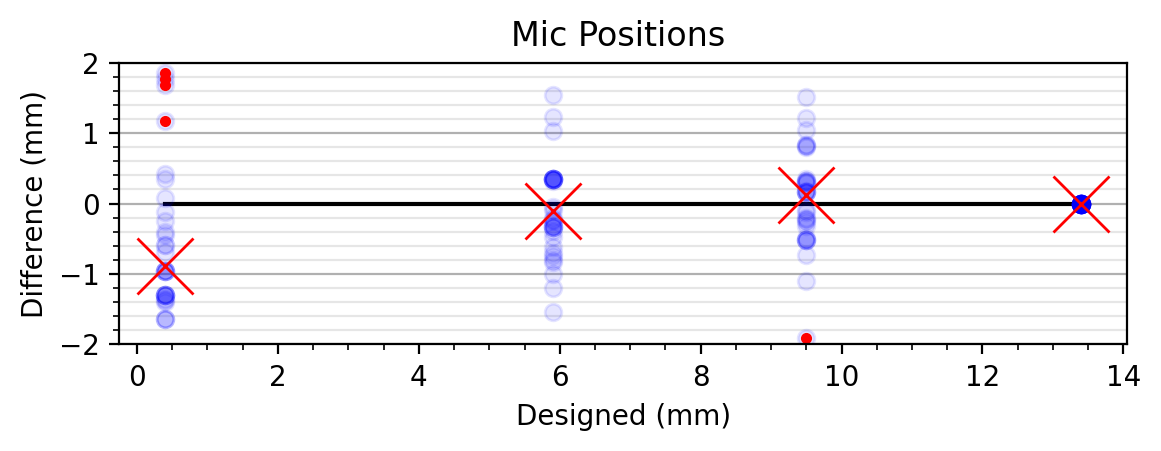

In [20]:
offset_nan = np.ones(offset_mask. shape)
offset_nan[offset_mask] = np.nan
plt.figure(**figkwargs)
plt.plot(lengths_nominal, lengths_nominal * 0, 'k')
plt.plot(lengths_nominal, fine_offsets.T - lengths_nominal[:, None], 'bo', alpha=0.1)
plt.plot(lengths_nominal, (fine_offsets.T - lengths_nominal[:, None]) * offset_nan.T, 'r.', alpha=1)
plt.plot(lengths_nominal, fine_offset - lengths_nominal, 'rx', ms=20)
plt.axis('scaled')
# plt.xlim([0, None])
plt.ylim([-2, 2])
plt.xlabel("Designed (mm)")
plt.ylabel("Difference (mm)")
plt.grid(which="major", axis="y")
plt.grid(True, which="minor", axis="y", color=(0.9, 0.9, 0.9))
plt.minorticks_on()
plt.title("Mic Positions ")

# 2. Amplitude Calibration

In [4]:
calibration_data = {"RL": 0.999, "R0": 0.999}  # We will store the calibration data here

## Load data

In [5]:
test_keys = ['cavern_1_B&K_in_probe_port', 'cavern_3_B&K_in_probe_port', 'cavern_4_B&K_in_probe_port']

times_owai = {}
data_owai = {}
times_ref = {}
data_ref = {}
fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][0][0])
_, _, samplerate = io.load_wav(fn)
# data_slice = slice(
#     int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate),
#     int(test_meta["chirp_parameters"]["end_time"]["value"] * samplerate))
data_slice = slice(int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate), None)  # Looking at the FFTs, doing the subsampling doesn't seem to make a difference
duration = test_meta["chirp_parameters"]["end_time"]["value"] - test_meta["chirp_parameters"]["start_time"]["value"]

for i, test_key in enumerate(test_keys):
    cavern_times = {}
    cavern_data = {}
    cavern_times_ref = {}
    cavern_data_ref = {}
    count = 0
    for j, tests in enumerate(test_meta["test_metadata"][test_key]["files"]):
        if len(tests) == 1:
            continue
        fn = os.path.join(path, tests[0])
        t, d, samplerate = io.load_wav(fn, )
        cavern_times["test%d"%count] = t[data_slice]
        cavern_data["test%d"%count] = d[data_slice].T
        fn = os.path.join(path, tests[1])
        t, d, samplerate_bk = io.load_wav(fn)
        slc = spu.trim_signal_sharp_jump(d, samplerate_bk, duration=5, kernel_size=65, end=True, return_index=True)
        cavern_times_ref["test%d"%count] = t[slc]
        cavern_data_ref["test%d"%count] = d[slc].T
        count += 1
    times_owai[test_key[:8]] = cavern_times
    data_owai[test_key[:8]] = cavern_data
    times_ref[test_key[:8]] = cavern_times_ref
    data_ref[test_key[:8]] = cavern_data_ref
# Done reading all the data

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-02-23_OWAI-Calibration-Data-Collection/BKProbe_001.dat
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-02-23_OW

## Sanity Checks


### Fourier transforms energy

Using scaling data from  /mnt/o/1010564-OPEN-HEARING/Technical Work/Testing/Data/2024-02-23_OWAI-Calibration-Data-Collection/BKProbe_001.dat


Text(0.5, 1.0, 'Good the clip B&K file, otherwise energy too low')

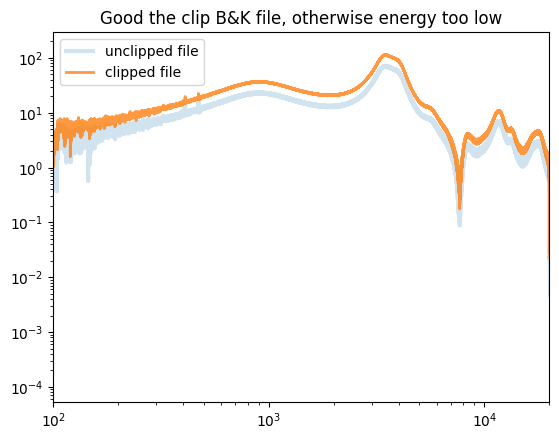

In [6]:
fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][1][1])
t, d, samplerate_bk = io.load_wav(fn)
f,a = spu.to_fourier(d, samplerate_bk)
slc = spu.trim_signal_sharp_jump(d, samplerate_bk, duration=5, kernel_size=65, end=True, return_index=True)
f2,a2 = spu.to_fourier(d[slc], samplerate_bk)

plt.figure(201)
plt.loglog(f, np.abs(a), alpha=0.2, lw=3, label="unclipped file")
plt.loglog(f2, np.abs(a2), alpha=0.8, lw=2, label="clipped file")
plt.xlim(100, 20000)
plt.legend()
plt.title("Good the clip B&K file, otherwise energy too low")

Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000


Text(0.5, 1.0, 'Clip Tympan file, no difference')

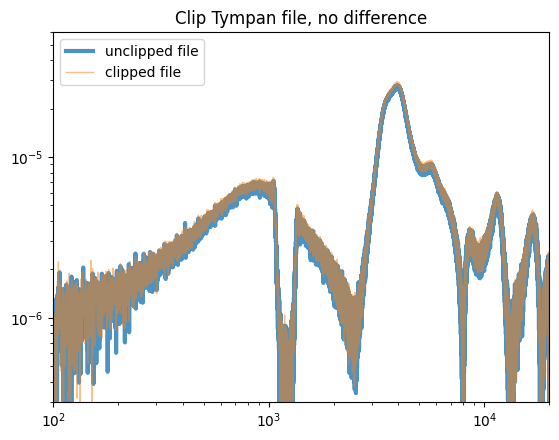

In [8]:
fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][1][0])
t, d, samplerate = io.load_wav(fn)
d = d[:, 2]
f,a = spu.to_fourier(d, samplerate)
f2,a2 = spu.to_fourier(d[data_slice], samplerate)

plt.figure(202)
plt.loglog(f, np.abs(a), alpha=0.8, lw=3, label="unclipped file")
plt.loglog(f2, np.abs(a2), alpha=0.5, lw=1, label="clipped file")
plt.xlim(100, 20000)
plt.ylim([3e-7, 6e-5])
plt.legend()
plt.title("Clip Tympan file, no difference")

### Test to Test Variability

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


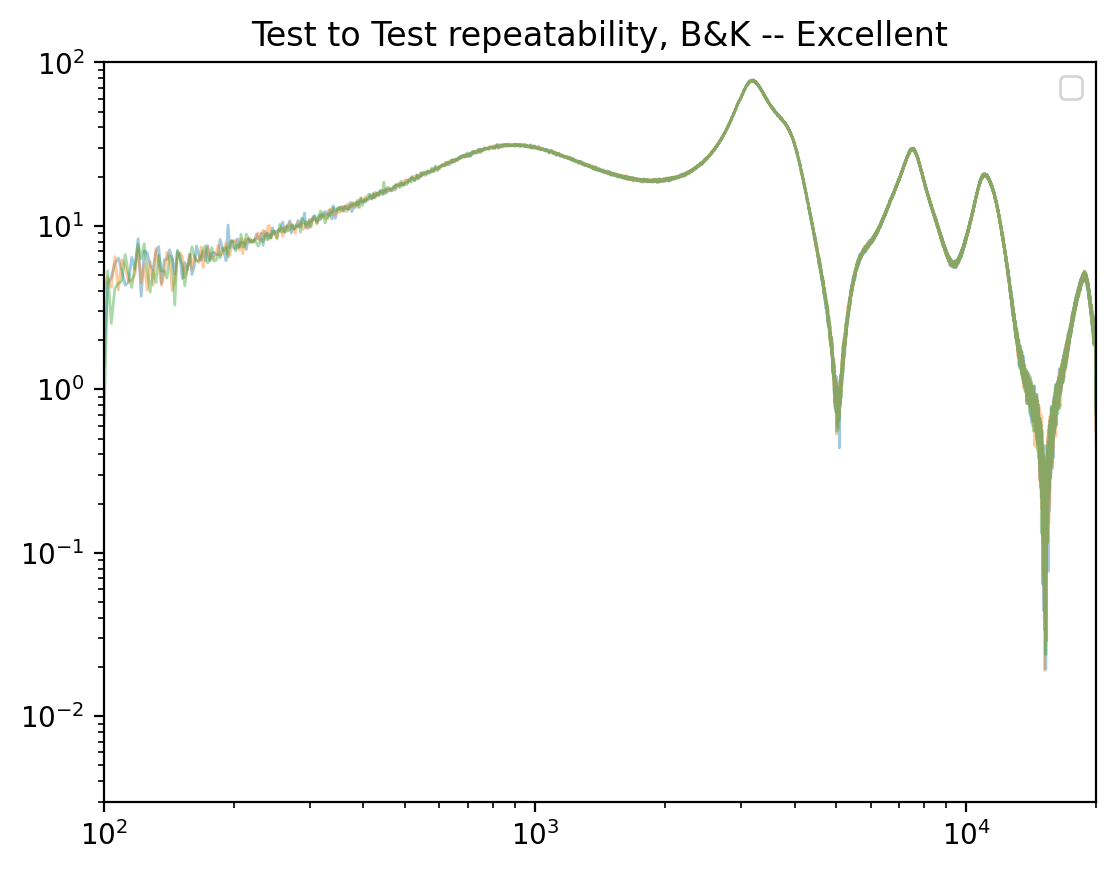

In [10]:
# Let's look at the consistency of the noises in the same cavern. Cavern 3 has the most data, so use it.
plt.figure(203, dpi=200)
cavern = 'cavern_3'
subsel = 10
for test in times_ref[cavern].keys():
    t = times_ref[cavern][test]
    d = data_ref[cavern][test]
    f,a = spu.to_fourier(d, samplerate_bk)
    plt.loglog(f[::subsel], np.abs(a)[::subsel], lw=1, alpha=0.4)
plt.xlim([100, 20000])
plt.ylim([3e-3, 1e2])
plt.legend()
plt.title("Test to Test repeatability, B&K -- Excellent")
plt.show()



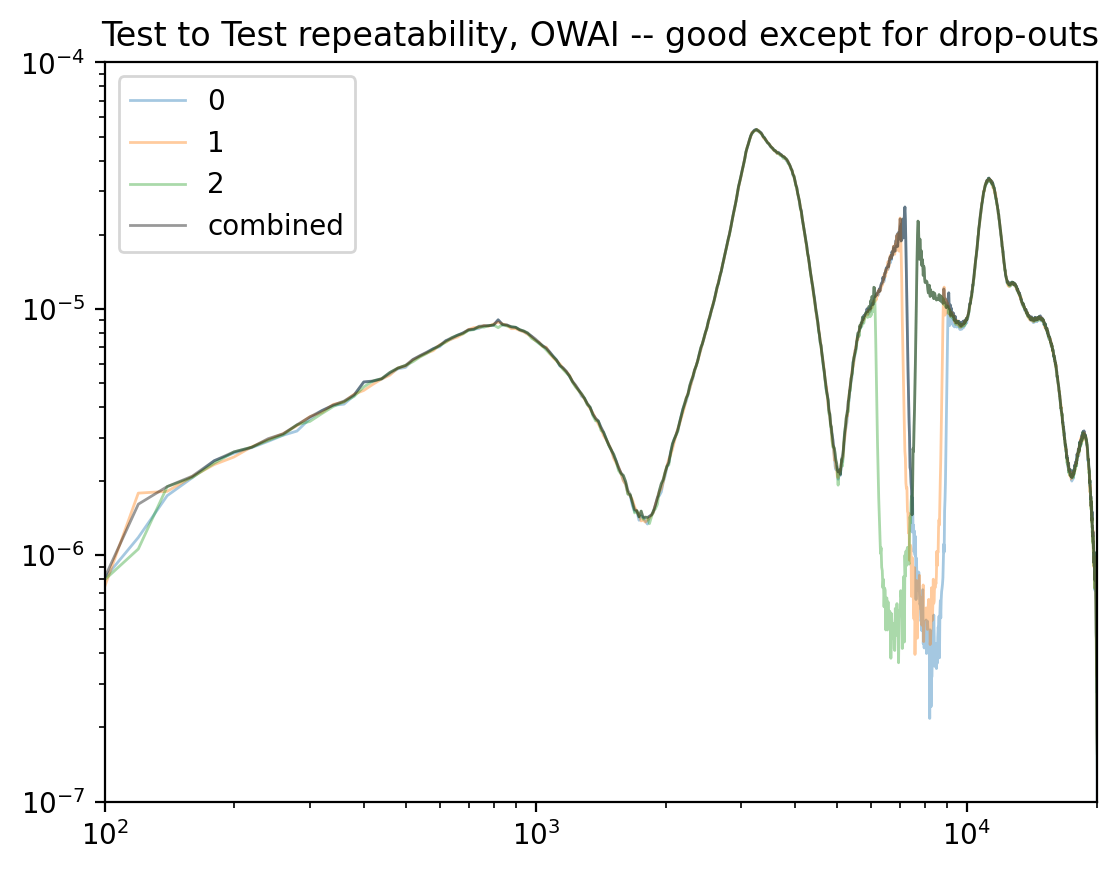

In [11]:
# Let's look at the consistency of the noises in the same cavern. Cavern 3 has the most data, so use it.
plt.figure(204, dpi=200)
subsel=100
cavern = 'cavern_3'
all_data = []
for test in times_ref[cavern].keys():
    t = times_owai[cavern][test]
    d = data_owai[cavern][test][0]
    f,a = spu.to_fourier(d, samplerate)
    all_data.append((f, np.abs(a)))
    plt.loglog(f[::subsel], np.abs(a)[::subsel], lw=1, alpha=0.4)
f, a = all_data[0]
for f2, a2 in all_data[1:]:
    a = np.maximum(a, np.interp(f, f2, a2))
plt.loglog(f[::subsel], np.abs(a)[::subsel], 'k', lw=1, alpha=0.4)
plt.legend(['0', '1', '2', 'combined'])
plt.xlim([100, 20000])
plt.ylim([1e-7, 1e-4])
plt.title("Test to Test repeatability, OWAI -- good except for drop-outs")
plt.show()



## Speaker Calibration



### Get the data and compute initial theoretical pressures

In [7]:
# For each cavern, check the BK data against the theoretical data
# cavern_ids = [1, 3, 4]
cavern_ids = [3, 4]  # 1 is being weird, didn't get data for 2
lp = test_meta["probe_geometry"]["length"]["value"] * units(test_meta["probe_geometry"]["length"]["units"])
ls = [lp + test_meta["test_geometry"]["cavern_" + str(i)]["length"]["value"] * units(test_meta["test_geometry"]["cavern_" + str(i)]["length"]["units"]) for i in cavern_ids]
x_probe = [
    lp + test_meta["test_geometry"]["cavern_" + str(i)]["x_of_probe"]["value"] * units(test_meta["test_geometry"]["cavern_" + str(i)]["x_of_probe"]["units"])
    for i in cavern_ids
    ]

# Arbitrarily use "test0", since repeatability was pretty good
test = 'test0'
fourier_ref = [spu.to_fourier(data_ref["cavern_" + str(i)][test], samplerate_bk) for i in cavern_ids]
f = np.stack([fr[0] for fr in fourier_ref], axis=0)
keep_inds = (f.min(axis=0) >= 100) & (f.max(axis=0) < 20000)
f = f[:, keep_inds] * units.Hz
p_ref = np.stack([fr[1][keep_inds] for fr in fourier_ref], axis=0)

# Create the theoretical pressure plots
nominal_cal_dB_at_f = np.stack([np.interp(fr.magnitude, speaker_cal[:, 0], speaker_cal[:, 1]) for fr in f], axis=0)
nominal_pa = [1] * len(ls)
R0 = RL = 0.999
tubes = [StraightTube(L=l, R0=R0, RL=RL, P0=nominal_pa[i], PL=0.0) for i, l in enumerate(ls)]
p_theory0 = np.stack([t.p(fr, x) for t, fr, x in zip(tubes, f, x_probe)], axis=0)

min_size = min([data_owai["cavern_" + str(i)][test].shape[1] for i in cavern_ids])
fourier_mic = [spu.to_fourier(data_owai["cavern_" + str(i)][test][:, :min_size], samplerate) for i in cavern_ids]
f_mic = np.stack([fr[0] for fr in fourier_mic], axis=0)
keep_inds = (f_mic.min(axis=0) >= 100) & (f_mic.max(axis=0) < 20000)
f_mic = f_mic[:, keep_inds] * units.Hz
p_mic = np.stack([fr[1][..., keep_inds] for fr in fourier_mic], axis=0)



/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


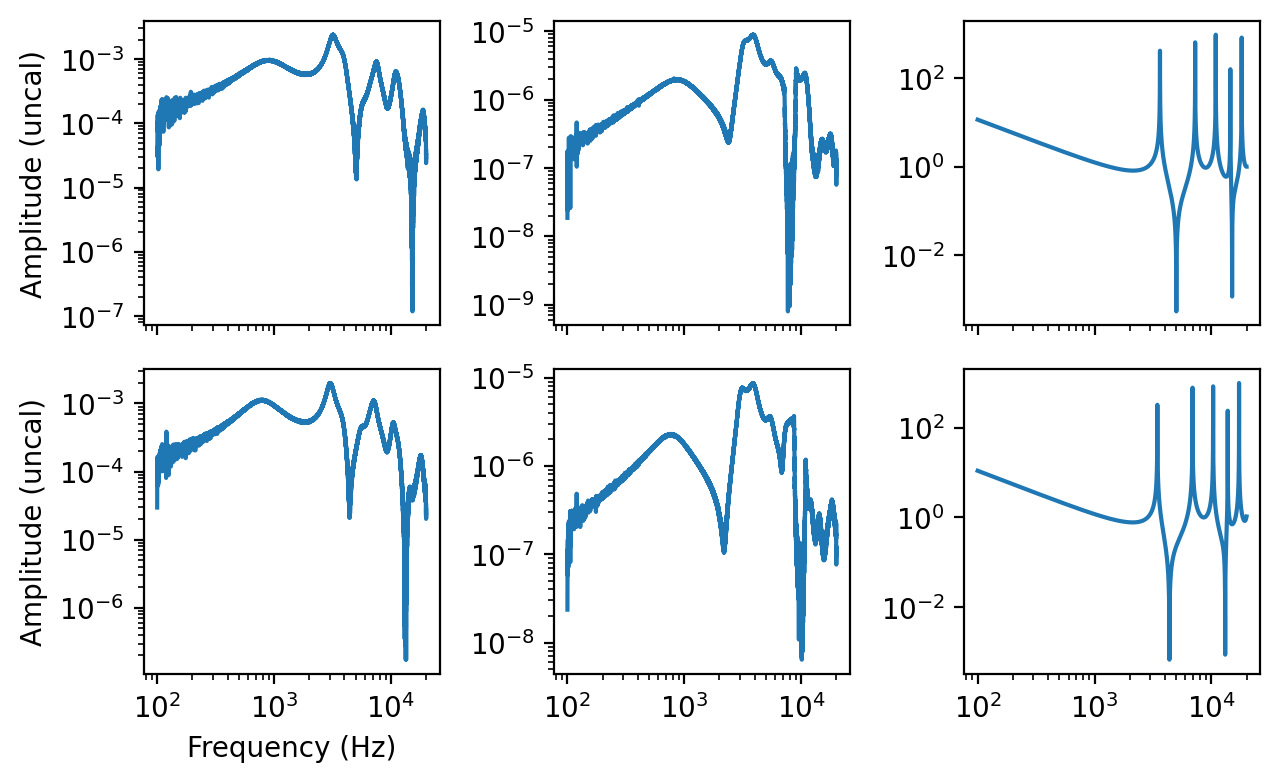

In [8]:
def plot_ref_theory(p_ref, p_theory, p_mic, fignum=1):
    fig, ax = plt.subplots(len(cavern_ids), 3, sharex=True, num=fignum, **figkwargs)
    for i in range(len(cavern_ids)):
        ax[i, 0].loglog(f[i], np.abs(p_ref[i]))
        ax[i, 1].loglog(f_mic[i], np.abs(p_mic[i, 3]))
        ax[i, 2].loglog(f[i], np.abs(p_theory[i]))
        ax[i, 0].set_ylabel('Amplitude (uncal)')
    ax[-1, 0].set_xlabel('Frequency (Hz)')
    plt.tight_layout()
plot_ref_theory(p_ref, p_theory0, p_mic, fignum=30)
plt.show()

### Optimize for the absorption loss globally

In [9]:
def update_p_theory(alpha, tubes):
    for t in tubes:
        t.absorption_loss = alpha
    p_theory = np.stack([t.p(fr, x) for t, fr, x in zip(tubes, f.T, x_probe)], axis=1)
    return p_theory
alpha0 = 0
alpha1 = 0.05
p_theory1 = update_p_theory(alpha1, tubes)
# plot_ref_theory(p_theory0, p_theory1, fignum=31)
plt.show()

#### Using ratio as maxes/mins in cost function -- not a good approach

[126.45240524032876 124.85900409754476 94.40458940817268] dimensionless [ 1422.12089669 23170.93392413  8387.40131808] 0 0.025 0.025
[475.81728937715366 482.8178992755724 367.83735807557287] dimensionless [ 1422.12089669 23170.93392413  8387.40131808] 0 0.0125 0.0125
[1794.4176985692561 1834.6333190945936 1415.1243292496997] dimensionless [ 1422.12089669 23170.93392413  8387.40131808] 0 0.00625 0.00625
[6512.4975816458 6671.595765351723 5265.226450911608] dimensionless [ 1422.12089669 23170.93392413  8387.40131808] 0 0.003125 0.003125
[21810.688270428658 22354.189886682598 18383.62636192346] dimensionless [ 1422.12089669 23170.93392413  8387.40131808] 0.0015625 0.0015625 0.003125
[10891.406666341374 11160.741278773836 8935.180916218453] dimensionless [ 1422.12089669 23170.93392413  8387.40131808] 0.0023437500000000003 0.0023437500000000003 0.003125
[8284.037073831854 8487.754213299611 6740.284563424767] dimensionless [ 1422.12089669 23170.93392413  8387.40131808] 0.0023437500000000003 

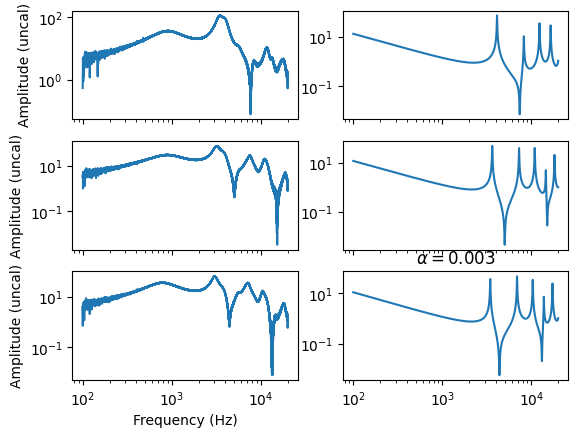

In [56]:
alpha0 = 0
alpha1 = 0.05
check_inds = np.all(f.magnitude > 2000, axis=1)
calc_ratio = lambda p: np.log10(np.abs(p[check_inds]).max(axis=0)) / np.log10(np.abs(p[check_inds]).min(axis=0))
calc_ratio = lambda p: (np.abs(p[check_inds]).max(axis=0)) / (np.abs(p[check_inds]).min(axis=0))
ratio = calc_ratio(p_ref)

ratio_theory0 = calc_ratio(p_theory0)
ratio_theory1 = calc_ratio(p_theory1)

# Use the bisection method
iter = 8
for i in range(iter):
    alpha_mid = (alpha0 + alpha1) / 2
    theory_mid = update_p_theory(alpha_mid, tubes)
    ratio_theory_mid = calc_ratio(theory_mid)
    # if np.sum(ratio_theory_mid > ratio) >= 2:
    if ratio_theory_mid[-1] < ratio[-1]:
        alpha1 = alpha_mid
    else:
        alpha0 = alpha_mid
    print(ratio_theory_mid, ratio, alpha0, alpha_mid, alpha1)

p_theoryf = update_p_theory(alpha_mid, tubes)
plot_ref_theory(p_ref, p_theoryf)
plt.title(r"$\alpha = %0.3f$" % alpha_mid)
plt.show()

### Using Amplitude and Global absorption correction

In [12]:
def update_p_theory(alpha, tubes, loff):
    for t, l in zip(tubes, ls):
        t.absorption_loss = alpha
        t.L = l + loff
    p_theory = np.stack([t.p(fr, x + loff) for t, fr, x in zip(tubes, f, x_probe)], axis=0)
    return p_theory


### Optimize for the line offsets

In [13]:
line_off_range = np.linspace(-2, 2, 32)
ptrange = np.stack([update_p_theory(0.0, tubes, lo * units.mm) for lo in line_off_range], axis=1)
theory_peaks = [[signal.find_peaks(np.abs(ptrange[i, j]), prominence=8)[0] for j in range(ptrange.shape[1])] for i in range(ptrange.shape[0])]

/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/scipy/signal/_peak_finding.py:266: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  value = np.asarray(value, order='C', dtype=np.float64)


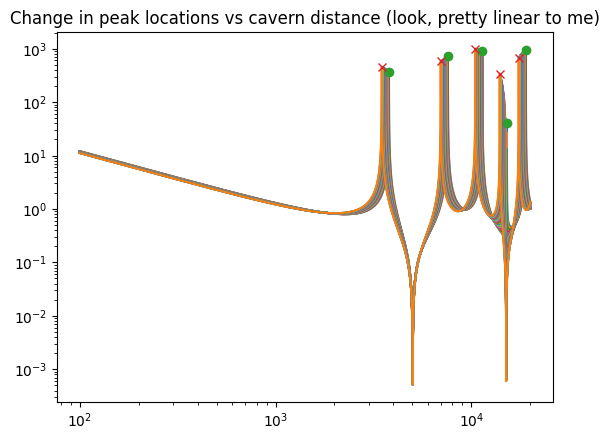

In [14]:
tn = 0
plt.title("Change in peak locations vs cavern distance (look, pretty linear to me)")
plt.loglog(f[tn], np.abs(ptrange[tn]).T)
plt.loglog(f[tn][theory_peaks[tn][0]], np.abs(ptrange[tn, 0, theory_peaks[tn][0]]), 'o')
plt.loglog(f[tn][theory_peaks[tn][-1]], np.abs(ptrange[tn, -1, theory_peaks[tn][-1]]), 'x')
plt.show()

In [15]:
theory_peaks_ends = [np.stack([tp[0][:4], tp[-1][:4]], axis=0) for tp in theory_peaks]
theory_peaks_ends

[array([[18466, 37432, 56398, 75364],
        [16925, 34349, 51774, 69198]]),
 array([[17472, 35445, 53417, 71389],
        [16082, 32664, 49246, 65829]])]

In [16]:
pref_peaks = [signal.find_peaks(np.abs(p_ref[i]), width=128)[0] for i in range(p_ref.shape[0])]
pref_peaks

[array([ 4117, 15450, 37028, 54468, 93889, 98824]),
 array([ 3522, 14678, 35354, 51912, 89862, 98826])]

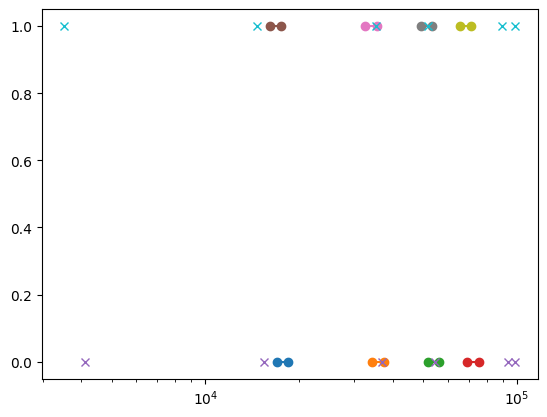

In [17]:
for tn in range(len(pref_peaks)):
    plt.semilogx(theory_peaks_ends[tn], theory_peaks_ends[tn]*0 + tn, 'o-')
    plt.semilogx(pref_peaks[tn], pref_peaks[tn]*0 + tn, 'x')
plt.show()

In [18]:
loff = []
for tn in range(len(pref_peaks)):
    in_between_limits = (pref_peaks[tn][:, None] >= theory_peaks_ends[tn][1:]) & (pref_peaks[tn][:, None] <= theory_peaks_ends[tn][:1])
    if np.all(in_between_limits):
        loff.append[0]
        continue
    inds = np.argwhere(in_between_limits)
    my_offsets = (pref_peaks[tn][inds[:, 0]] - theory_peaks_ends[tn][1, inds[:, 1]]) \
        / (theory_peaks_ends[tn][0, inds[:, 1]] - theory_peaks_ends[tn][1, inds[:, 1]]) \
        * (line_off_range[-1] - line_off_range[0]) + line_off_range[0]
    loff.append(my_offsets.mean())
loff = np.array(loff)

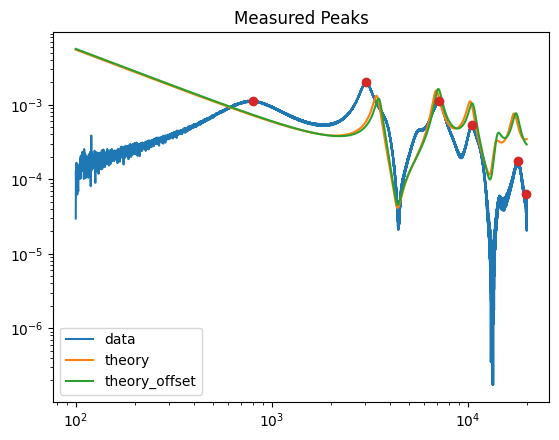

In [23]:
tn = 1
tubes[tn].absorption_loss = 0.04
tubes[tn].L = ls[tn]
p_theory0 = np.abs(tubes[tn].p(f, x_probe[tn])) / 2000
tubes[tn].L = ls[tn] - loff[tn] * units.mm
p_theory1 = np.abs(tubes[tn].p(f, x_probe[tn] - loff[tn] * units.mm)) / 2000

plt.title("Measured Peaks")
plt.loglog(f[tn], np.abs(p_ref[tn]).T)
plt.loglog(f[tn], np.abs(p_theory0[tn]).T)
plt.loglog(f[tn], np.abs(p_theory1[tn]).T)
plt.legend(["data", "theory", "theory_offset"])
plt.loglog(f[tn][pref_peaks[tn]], np.abs(p_ref[tn, pref_peaks[tn]]), 'o')
plt.show()

In [43]:

# p_ref_sa = ndimage.gaussian_filter1d(np.abs(p_ref), 100, axis=-1)
# p_ref_mins_f = ndimage.minimum_filter1d(p_ref_sa, 1024, axis=-1)
# p_ref_mins_i = (p_ref_sa == p_ref_mins_f) & (f.magnitude > 1000)

# cal_min_i = np.argmax(p_ref_mins_i, axis=-1)

# plt.loglog(f[0], p_ref_sa[0])
# plt.loglog(f[0], p_ref_mins_f[0])
# plt.loglog(f[0, p_ref_mins_i[0]], p_ref_sa[0, p_ref_mins_i[0]], 'o')
# plt.loglog(f[0, cal_min_i[0]], p_ref_sa[0, cal_min_i[0]], 'x')
# plt.loglog(f[1, cal_min_i[1]], p_ref_sa[1, cal_min_i[1]], 'x')
# # plt.loglog(f[2, cal_min_i[2]], p_ref_sa[2, cal_min_i[2]], 'x')
# plt.show()

In [44]:

# cal_f = f[range(len(cal_min_i)), cal_min_i]
# cal_amp = p_ref_sa[range(len(cal_min_i)), cal_min_i]

# def plot_cal_speak(p_ref, p_theory, cal_amp, fignum):
#     fig, ax = plt.subplots(len(cavern_ids), 1, sharex=True, num=fignum, **figkwargs)
#     for i in range(len(cavern_ids)):
#         ax[i].loglog(f[i], np.abs(p_ref[i]))
#         ax[i].loglog(f[i], np.abs(p_theory[i] * cal_amp[i]))
#         ax[i].set_ylabel('Amplitude (uncal)')
#     ax[0].set_xlabel('Frequency (Hz)')
#     plt.tight_layout()
# plot_cal_speak(p_ref, p_theory0, cal_amp, 31)

# p_theory1 = update_p_theory(0.01, tubes)
# plot_cal_speak(p_ref, p_theory1, cal_amp, 32)
# p_theory1 = update_p_theory(0.02, tubes)
# plot_cal_speak(p_ref, p_theory1, cal_amp, 33)
# p_theory1 = update_p_theory(-0.02, tubes)
# plot_cal_speak(p_ref, p_theory1, cal_amp, 34)
# plt.show()


### Use Optimization to get close

#### Confirm we can just multiply the pressure amplitude

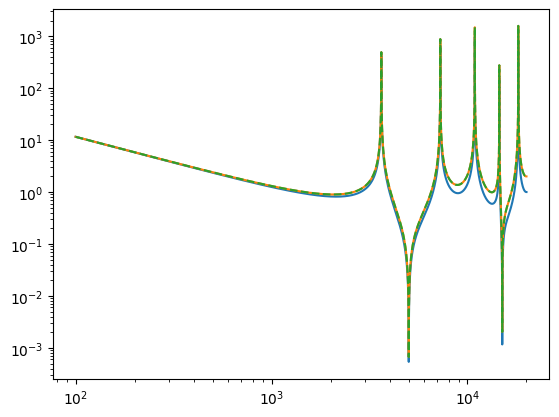

In [9]:
test_tube = StraightTube(L=ls[0], R0=R0, RL=RL, P0=1.0, PL=0.0)
p1 = np.abs(test_tube.p(f[0], x_probe[0]))
Pramp  = np.linspace(1, 2, f[0].size)
test_tube2 = StraightTube(L=ls[0], R0=R0, RL=RL, P0=Pramp, PL=0.0)
p2 = np.abs(test_tube2.p(f[0], x_probe[0]))
p3 = p1 * Pramp

plt.loglog(f[0], p1)
plt.loglog(f[0], p2)
plt.loglog(f[0], p3, '--')
plt.show()

#### Global

In [46]:
# def cost(x, tube, l, xp, f, p_ref):
#     loff, amp, alpha = x
#     tube.absorption_loss = alpha
#     tube.L = l + loff * units.mm
#     p_theory = np.abs(tube.p(f, xp + loff * units.mm) * amp)
#     return np.linalg.norm(p_ref - p_theory)

# res = optimize.minimize(
#     cost,
#     [0, np.abs(p_ref[0]).mean(), 0.01],
#     args=(tubes[0], ls[0], x_probe[0], f[0], np.abs(p_ref[0])), method="Nelder-Mead")

In [47]:
# loff, amp, alpha = res.x
# tubes[0].absorption_loss = alpha
# tubes[0].L = ls[0] + 0*loff * units.mm
# p_theory = tubes[0].p(f[0], x_probe[0] + 0*loff * units.mm) * amp

# plt.loglog(f[0], np.abs(p_theory))
# plt.loglog(f[0], np.abs(p_ref[0]))
# plt.show()

In [24]:
def cost(x, tube, l, xp, f, p_ref):
    amp, alpha = x
    tube.absorption_loss = alpha
    tube.L = l
    p_theory = np.abs(tube.p(f, xp) * amp)
    return np.linalg.norm(p_ref - p_theory)

res = []
for i in range(p_ref.shape[0]):
    resl = optimize.minimize(
        cost,
        [np.abs(p_ref[i]).mean(), 0.01],
        args=(tubes[i], ls[i] - loff[i] * units.mm, x_probe[i] - loff[i] * units.mm, f[i], np.abs(p_ref[i])), method="Nelder-Mead")
    res.append(resl)
    print(resl.x)

/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/scipy/optimize/_optimize.py:646: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fx = np.asarray(fx).item()


[0.00028045 0.03554954]
[0.00027865 0.0402842 ]


In [49]:
# tn = 0
# amp, alpha = res[tn].x
# tubes[tn].absorption_loss = alpha
# tubes[tn].L = ls[tn]
# p_theory = tubes[tn].p(f[tn], x_probe[tn]) * amp

# plt.loglog(f[tn], np.abs(p_theory))
# plt.loglog(f[tn], np.abs(p_ref[tn]))
# plt.show()

In [25]:
p_theory = []
for tn in range(len(res)):
    amp, alpha = res[tn].x
    tubes[tn].absorption_loss = alpha
    tubes[tn].L = ls[tn] -loff[tn] * units.mm
    my_p_theory = tubes[tn].p(f[tn], x_probe[tn] -loff[tn] * units.mm)
    p_theory.append(my_p_theory)
p_theory = np.stack(p_theory, axis=0)
p_mag_cal = p_ref / p_theory

In [26]:
20 * np.log10(np.abs(p_ref) / 20e-6).max()  # Scaling looks pretty good

41.54479517618846

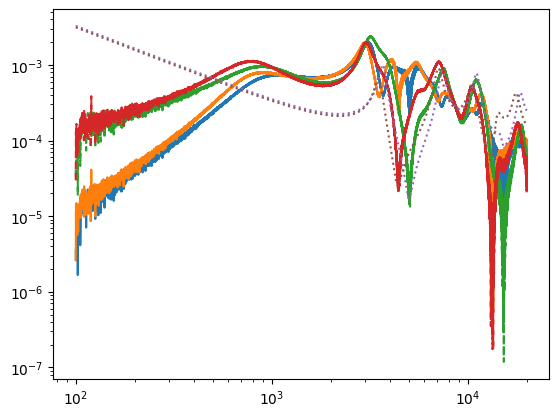

In [27]:
plt.loglog(f.T, np.abs(p_mag_cal).T)
plt.loglog(f.T, np.abs(p_ref).T, '--')
# plt.loglog(f.T, (np.abs(p_theory) * np.abs(p_mag_cal)).T, '--')
plt.loglog(f.T, (np.abs(p_theory) * amp).T, ':')
plt.show()


In [28]:

# Fit a polynomial to the correction, and that will calibrate our speakers
# polydata = np.polyfit(np.log(f.magnitude).ravel(), np.abs(p_mag_cal.magnitude).ravel(), w=1/np.log(f.magnitude.ravel()), deg=8)
# polydata = np.polyfit(f.magnitude.ravel(), np.log(np.abs(p_mag_cal.magnitude).ravel()), w=1/f.magnitude.ravel(), deg=9)
polydata0 = np.polyfit(np.log10(f.magnitude.ravel()), np.log10(np.abs(p_mag_cal.magnitude).ravel()), w=1/f.magnitude.ravel(), deg=7)
# polydata0 = np.polyfit(np.log10(f.magnitude.ravel()), np.log10(np.abs(p_mag_cal.magnitude).ravel()), w=1/np.log10(f.magnitude.ravel()), deg=7)
polydata1 = np.polyfit(np.log10(f.magnitude.ravel()), np.log10(np.abs(p_mag_cal.magnitude).ravel()), deg=7)
# polydata = np.polyfit(np.log(f.magnitude).ravel(), np.abs(p_mag_cal.magnitude).ravel(), deg=5)
calibration_data["f"] = f  # Simpler version, works great
calibration_data["speaker"] = polydata1  # Simpler version, works great
calibration_data["speaker_lambda"] = lambda f, p: 10**np.polyval(p, np.log10(f))
calibration_data["speaker_length_offset"] = loff * units.mm
calibration_data["speaker_absorption"] = np.array([r.x[1] for r in res])
calibration_data["speaker_at_f"] = 10**np.polyval(polydata1, np.log10(f.magnitude)) # Simpler version, works great
calibration_data["speaker_at_f_mic"] = 10**np.polyval(polydata1, np.log10(f_mic.magnitude)) # Simpler version, works great

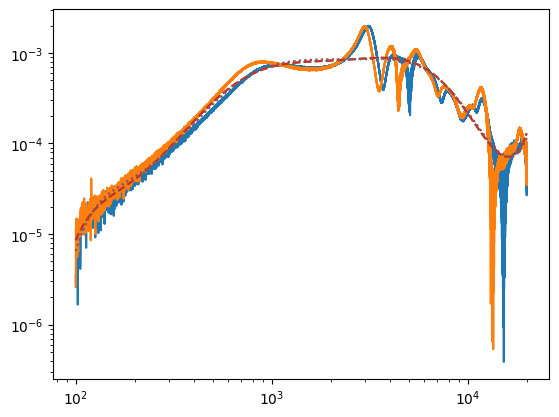

In [29]:
plt.loglog(f.T, np.abs(p_mag_cal).T)
# plt.loglog(f.T, np.polyval(polydata, np.log(f.magnitude)).T, '--')
plt.loglog(f.T, 10**np.polyval(polydata0, np.log10(f.magnitude)).T, '--')
plt.loglog(f.T, 10**np.polyval(polydata1, np.log10(f.magnitude)).T, ':')
plt.show()

# Mic Amplitude Calibration

In [30]:
tubes = []
for i, l in enumerate(ls):
    t = StraightTube(
        L=l - calibration_data['speaker_length_offset'][i],
        R0=R0,
        RL=RL,
        P0=calibration_data['speaker_at_f_mic'][i],
        PL=0.0,
    )
    t.absorption_loss = calibration_data['speaker_absorption'][i]
    tubes.append(t)

x_mic = np.array(test_meta["probe_geometry"]["mic_positions"]["value"]) * units(test_meta["probe_geometry"]["mic_positions"]["units"])
p_theory = np.stack([tubes[i].p(f_mic[i], x_mic[:, None]) for i in range(f_mic.shape[0])], axis=0)

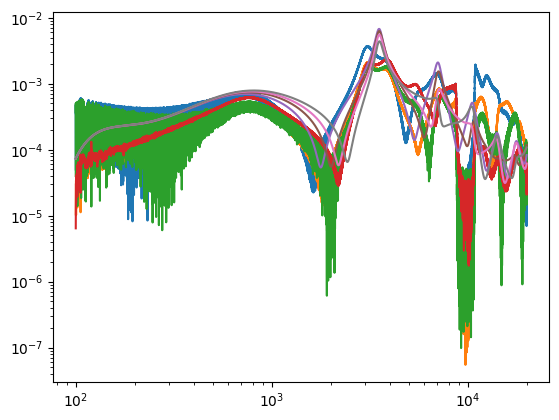

In [31]:
tn = 1
plt.loglog(f_mic[tn], np.abs(p_mic[tn]).T / np.abs(p_mic[tn]).mean() * np.abs(p_theory[tn]).mean())
plt.loglog(f_mic[tn], np.abs(p_theory[tn]).T)
plt.show()

In [32]:
mic_mag_cal = np.abs(p_theory / p_mic)
deg = 5
mic_polydata0 = [np.polyfit(np.log10(f_mic.ravel().magnitude), np.log10(mic_mag_cal[:, i].ravel().magnitude), deg=deg) for i in range(p_mic.shape[1])]
mic_polydata1 = [np.polyfit(np.log10(f_mic.ravel().magnitude), np.log10(mic_mag_cal[:, i].ravel().magnitude), deg=deg, w=1/f_mic.magnitude.ravel()) for i in range(p_mic.shape[1])]

mic_polyval0 = np.stack([10 ** np.polyval(mic_polydata0[i], np.log10(f_mic[0].magnitude)) for i in range(4)], axis=0)
mic_polyval1 = np.stack([10 ** np.polyval(mic_polydata1[i], np.log10(f_mic[0].magnitude)) for i in range(4)], axis=0)

calibration_data["mic"] = mic_polydata1
calibration_data["mic_lambda"] = lambda f, poly: 10 ** np.polyval(poly, np.log10(f))
calibration_data["mic_at_f_mic"] = mic_polyval1
calibration_data["f_mic"] = f_mic


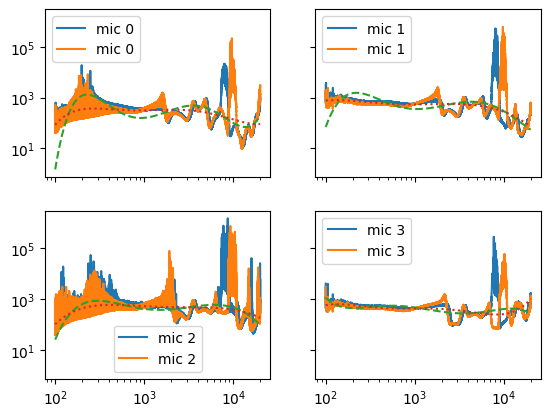

In [33]:

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        ax[i,j].loglog(f_mic[0], mic_mag_cal[:, ii].T, label="mic %d" % ii)
        ax[i,j].loglog(f_mic[0], mic_polyval0[ii], '--')
        ax[i,j].loglog(f_mic[0], mic_polyval1[ii], ':')
        ax[i,j].legend()
plt.show()

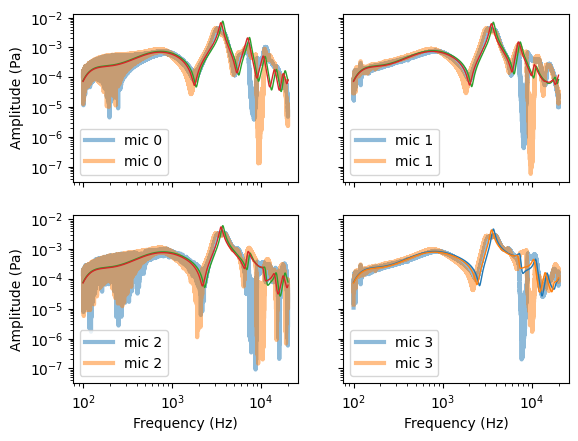

In [34]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        ax[i,j].loglog(f_mic[0], np.abs(p_mic[:, ii] * mic_polyval1[ii][None]).T, label="mic %d" % ii, alpha=0.5, lw=3)
        plt.gca().set_prop_cycle(None)
        ax[i,j].loglog(f_mic[0], np.abs(p_theory[:, ii]).T, '-', lw=1)
        ax[i,j].legend()
    ax[1, 0].set_xlabel("Frequency (Hz)")
    ax[1, 1].set_xlabel("Frequency (Hz)")
    ax[0, 0].set_ylabel("Amplitude (Pa)")
    ax[1, 0].set_ylabel("Amplitude (Pa)")
plt.show()

# 3. Phase Calibration

## Load the data

In [35]:
test_keys = ['cavern_1_probe_port_sealed','cavern_2_probe_port_sealed','cavern_3_probe_port_sealed','cavern_4_probe_port_sealed']

fn = os.path.join(path, test_meta["test_metadata"][test_keys[0]]["files"][0][0])
_, _, samplerate = io.load_wav(fn)
# data_slice = slice(
#     int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate),
#     int(test_meta["chirp_parameters"]["end_time"]["value"] * samplerate))
data_slice = slice(int(test_meta["chirp_parameters"]["start_time"]["value"] * samplerate), None)  # Looking at the FFTs, doing the subsampling doesn't seem to make a difference
duration = test_meta["chirp_parameters"]["end_time"]["value"] - test_meta["chirp_parameters"]["start_time"]["value"]

times_owai_sealed = {}
data_owai_sealed = {}
for i, test_key in enumerate(test_keys):
    cavern_times = {}
    cavern_data = {}
    count = 0
    for j, tests in enumerate(test_meta["test_metadata"][test_key]["files"]):
        fn = os.path.join(path, tests[0])
        t, d, samplerate = io.load_wav(fn, )
        cavern_times["test%d"%count] = t[data_slice]
        cavern_data["test%d"%count] = d[data_slice].T
        count += 1
    times_owai_sealed[test_key[:8]] = cavern_times
    data_owai_sealed[test_key[:8]] = cavern_data

cavern_ids = [1, 2, 3, 4]
lp = test_meta["probe_geometry"]["length"]["value"] * units(test_meta["probe_geometry"]["length"]["units"])
ls = [lp + test_meta["test_geometry"]["cavern_" + str(i)]["length"]["value"] * units(test_meta["test_geometry"]["cavern_" + str(i)]["length"]["units"]) for i in cavern_ids]
x_mic = np.array(test_meta['probe_geometry']['mic_positions']['value']) * units(test_meta['probe_geometry']['mic_positions']['units'])


# Arbitrarily use "test0", since repeatability was pretty good
test = 'test0'
min_size = min([data_owai_sealed["cavern_" + str(i)][test].shape[1] for i in cavern_ids])
fourier_mic = [spu.to_fourier(data_owai_sealed["cavern_" + str(i)][test][:, :min_size], samplerate) for i in cavern_ids]
f_mic = np.stack([fr[0] for fr in fourier_mic], axis=0)
keep_inds = (f_mic.min(axis=0) >= 100) & (f_mic.max(axis=0) < 20000)
f_mic = f_mic[:, keep_inds] * units.Hz
p_mic = np.stack([fr[1][..., keep_inds] for fr in fourier_mic], axis=0)


Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgBytesPerSec = 192000
Couldn't read file using scipy, falling back to soundfile. This was the error  WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 96000, nBlockAlign = 8, and nAvgB

TypeError: 'int' object is not subscriptable

In [43]:
# Create the initial theoretical pressures
tubes = []
p_theory0 = []
for i in range(len(cavern_ids)):
    nominal_pa = calibration_data['speaker_lambda'](f_mic[i].magnitude, calibration_data['speaker'])[None]
    R0 = calibration_data['R0']
    RL = calibration_data['RL']
    tube = StraightTube(L=ls[i], R0=R0, RL=RL, P0=nominal_pa, PL=0.0)
    tube.absorption_loss = calibration_data["speaker_absorption"].mean()
    my_p_theory0 = tube.p(f_mic[i][None], x_mic[:, None])
    p_theory0.append(my_p_theory0)
p_theory0 = np.stack(p_theory0, axis=0)

In [40]:
# Apply mic calibration
p_mic_cal = np.zeros_like(p_mic)
for i in range(len(cavern_ids)):
    p_mic_cal[i] = p_mic[i] * calibration_data['mic_lambda'](f_mic[i].magnitude, calibration_data['mic'][i])

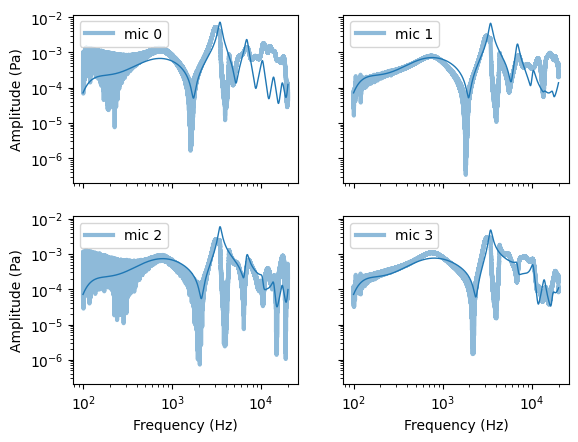

In [105]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
tn = 3
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        ax[i,j].loglog(f_mic[0], np.abs(p_mic_cal[tn, ii]).T, label="mic %d" % ii, alpha=0.5, lw=3)
        ax[i,j].set_prop_cycle(None)
        ax[i,j].loglog(f_mic[0], np.abs(p_theory0[tn, ii]).T, '-', lw=1)
        ax[i,j].legend()
    ax[1, 0].set_xlabel("Frequency (Hz)")
    ax[1, 1].set_xlabel("Frequency (Hz)")
    ax[0, 0].set_ylabel("Amplitude (Pa)")
    ax[1, 0].set_ylabel("Amplitude (Pa)")
plt.show()

### Try all the parameters to see if we can get a better fit
mini-conclusion reached by playing with the model: Maybe R0 = 0.6 and alpha = 0.02 looks better? Hard for an optimzer to do anything

In [88]:
# Let's optimize the snot out of one mic and one channel
def cost(x, tube, l, xp, f, p_ref):
    R0, RL, alpha = x
    tube.absorption_loss = alpha
    tube.L = l
    tube.R0 = R0
    tube.RL = RL
    p_theory = np.abs(tube.p(f, xp))
    return np.linalg.norm(np.log10(p_ref) - np.log10(p_theory))
tube.P0 = calibration_data['speaker_lambda'](f_mic[i].magnitude, calibration_data['speaker'])[None]
resl = optimize.minimize(
    cost,
    [0.999, 0.999, calibration_data["speaker_absorption"].mean()],
    args=(tube, ls[-1], x_mic[-1], f_mic[-1], np.abs(p_mic[-1, -1])), method="CG")

print(resl.x)

/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:149: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fx = np.asarray(fx).item()
/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/pint/facets/numpy/numpy_func.py:307: RuntimeWarning: overflow encountered in exp
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: overflow encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/mpu/.pyenv/versions/3.11.2/envs/owai/lib/python3.11/site-packages/pint/facets/plain/quantity.py:97

[-5396.92357423 -9793.7145941  19921.61877293]


In [92]:
# Do a simple grid search
tube.L = ls[-1]
R0Ls =  np.linspace(0.7,.999, 16)
alpha =  np.linspace(calibration_data["speaker_absorption"].mean() / 2, calibration_data["speaker_absorption"].mean() * 2, 16)
cost = np.zeros((R0Ls.size, R0Ls.size, alpha.size)) + np.inf
tube.P0 = calibration_data['speaker_lambda'](f_mic[-1].magnitude, calibration_data['speaker'])[None]
for i in range(R0Ls.size):
    for j in range(R0Ls.size):
        for k in range(alpha.size):
            tube.absorption_loss = alpha[k]
            tube.R0 = R0Ls[i]
            tube.RL = R0Ls[j]
            p_theory = np.abs(tube.p(f_mic[-1], x_mic[-1]))
            cost[i, j, k] = np.linalg.norm(np.log10(p_mic[-1, -1]) - np.log10(p_theory))
    print("Done", i, j, k, cost.min())

Done 0 15 15 1455.3216161015878
Done 1 15 15 1455.3199733789424
Done 2 15 15 1455.3182643687762
Done 3 15 15 1455.3164700783348
Done 4 15 15 1455.314569671573
Done 5 15 15 1455.312540270917
Done 6 15 15 1455.3103567349565
Done 7 15 15 1455.3079914089133
Done 8 15 15 1455.3054138442826
Done 9 15 15 1455.302590483567
Done 10 15 15 1455.2994843055292
Done 11 15 15 1455.2940756815747
Done 12 15 15 1455.2467919141297
Done 13 15 15 1455.1913244406555
Done 14 15 15 1455.1266160810912
Done 15 15 15 1455.051623569314


In [94]:
np.linalg.norm(np.log10(p_mic[-1, -1]) - np.log10(p_theory))

1455.051623569314 <Unit('dimensionless')>

In [82]:
np.linalg.norm(np.log10(p_mic[-1, -1]) - np.log10(p_theory0[-1, -1]))

1744.2489388586216 <Unit('dimensionless')>

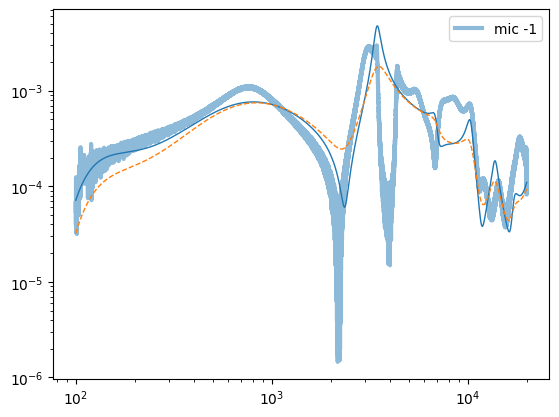

In [102]:
i, j, k = np.argwhere(cost == cost.min())[0]
i,j,k=15,0,9
tn = ii = -1
tube.absorption_loss = alpha[k]
tube.R0 = R0Ls[i]
tube.RL = R0Ls[j]
# tube.absorption_loss = calibration_data["speaker_absorption"].mean()
# tube.R0 = 0.999
# tube.RL = 0.999
p_theory = np.abs(tube.p(f_mic[-1], x_mic[-1]))
plt.loglog(f_mic[0], np.abs(p_mic_cal[tn, ii]).T, label="mic %d" % ii, alpha=0.5, lw=3)
plt.gca().set_prop_cycle(None)
plt.loglog(f_mic[0], np.abs(p_theory0[tn, ii]).T, '-', lw=1)
plt.loglog(f_mic[0], np.abs(p_theory).T, '--', lw=1)
plt.legend()

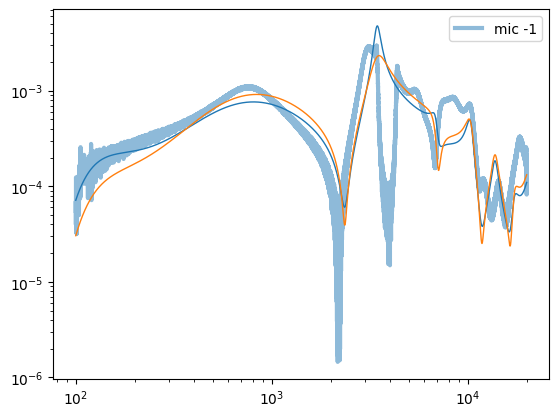

In [104]:
tn = ii = -1
tube.R0 = resl.x[0]
tube.RL = resl.x[1]
tube.absorption_loss = resl.x[2]
tube.R0 = 0.6
tube.RL = 0.999
tube.absorption_loss = 0.02
p_theory1 = np.abs(tube.p(f_mic[-1], x_mic[-1]))
plt.loglog(f_mic[0], np.abs(p_mic_cal[tn, ii]).T, label="mic %d" % ii, alpha=0.5, lw=3)
plt.gca().set_prop_cycle(None)
plt.loglog(f_mic[0], np.abs(p_theory0[tn, ii]).T, '-', lw=1)
plt.loglog(f_mic[0], np.abs(p_theory1).T, '-', lw=1)
plt.legend()

### Calibrate Phase
Plan is:
* speaker is the boss! Has zero phase. Each mic has to match whatever the theory predicts. Done. 

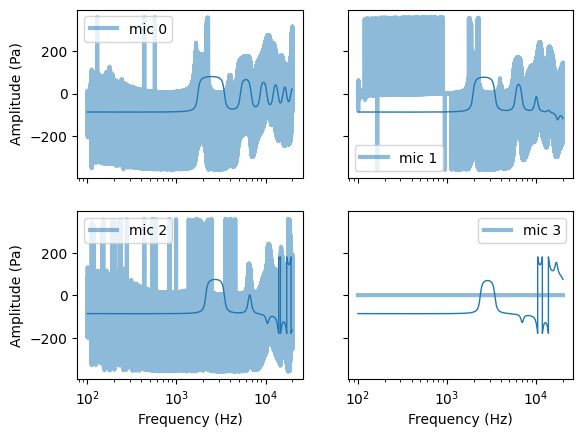

In [108]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
tn = 3
for i in range(2):
    for j in range(2):
        ii = i * 2 + j
        ax[i,j].semilogx(f_mic[0], np.rad2deg(np.angle(p_mic_cal[tn, ii])).T, label="mic %d" % ii, alpha=0.5, lw=1)
        ax[i,j].set_prop_cycle(None)
        ax[i,j].semilogx(f_mic[0], np.rad2deg(np.angle(p_theory0[tn, ii].magnitude)).T, '-', lw=1)
        ax[i,j].legend()
    ax[1, 0].set_xlabel("Frequency (Hz)")
    ax[1, 1].set_xlabel("Frequency (Hz)")
    ax[0, 0].set_ylabel("Amplitude (Pa)")
    ax[1, 0].set_ylabel("Amplitude (Pa)")
plt.show()